In [50]:
import psycopg2

def get_svv_connection():
    con=psycopg2.connect(dbname= 'svv', host='svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                         port= 5439, user= 'ryanw', password= 'hT6Y3TeZZUFdvLj')
    
    return con

In [51]:
##import svv_connector as svv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections as col
import datetime as dt
import operator

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from yellowbrick.classifier import ClassPredictionError

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


# own module to get one-hot encoding get_dummies-style
from get_smarties import Smarties

pd.set_option('display.max_rows', 1000)
%matplotlib inline

# Sample N Random Data Points from SVV

In [52]:
# how many rows do we need
N = 300000

table_to_query = 'viewers_summary_hc_2018_es'

used_columns =  " viewer_id, gender, age, title, barb, lifestage, " + \
                " pc_h_resident_property_val_perc, pc_p_personal_income_band_v3, " + \
                " pc_h_household_comp, pc_h_income_band_v3, " + \
                " pc_length_of_residence, pc_h_lifestage, pc_h_number_of_bedrooms, pc_p_marital_status, " + \
                " pc_h_prperty_type_v2, pc_h_family_lifestage_2011, pc_h_lone_parent, pc_young_person_at_addr, " + \
                " pc_p_affluence_v2, pc_h_affluence_v2, h_households_with_children_v3, " + \
                " p_personal_income_band_v3, h_income_band_v3, " + \
                " weekday_streaming, nonweekday_streaming, " + \
                " top_genre_id, top_subgenre, watch_ch_content_sum, watch_diverse_ch_content_sum, " + \
                " watch_parents_content_sum, watch_repeat_ch_content_sum, watch_ch_oi_content_sum, top_hour_of_day, " + \
                " top_hour_of_day_ch_content, top_hour_of_day_choi_content, percent_weekday_streaming, weekday_view_bucket, " + \
                " area_class1, area_class2, area_class3, " + \
                " avg_sprbrk_viewing, avg_sumbrk_viewing, avg_nonsch_hol_viewing, avg_sprbrk_ch_viewing, " + \
                " avg_sumbrk_ch_viewing, avg_nonsch_hol_ch_viewing "

query_data = "Select " + used_columns + \
                 " from sandbox.viewers_summary_hc_2018_es where viewer_id in" + \
                 " (select viewer_id from sandbox.viewers_summary_hc_2018_es" + \
                 " group by viewer_id order by md5('seed' || viewer_id) limit " + str(N) + ");"


dfRandomN = pd.DataFrame()


try: 
    con = get_svv_connection()

    cur = con.cursor()
    cur.execute(query_data)

    cols = [item.lstrip().rstrip() for item in used_columns.split(',')]
    dfRandomN = pd.DataFrame(cur.fetchall(), columns = cols)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

# Make Some Columns Numeric Type

In [53]:
dfRandomN['h_households_with_children_v3_int']=list(map(int, dfRandomN['h_households_with_children_v3']))
dfRandomN['pc_h_resident_property_val_perc_int'] = list(map(int, dfRandomN['pc_h_resident_property_val_perc']))

dfRandomN['pc_p_personal_income_band_v3_int'] = list(map(int, dfRandomN['pc_p_personal_income_band_v3']))

dfRandomN['pc_h_income_band_v3_int'] = list(map(int, dfRandomN['pc_h_income_band_v3']))

In [54]:
dfRandomN['pc_length_of_residence_int'] = list(map(int, dfRandomN['pc_length_of_residence']))
dfRandomN['pc_h_number_of_bedrooms_int'] = list(map(int, dfRandomN['pc_h_number_of_bedrooms']))

dfRandomN['pc_p_affluence_v2_int']=list(map(int, dfRandomN['pc_p_affluence_v2']))
dfRandomN['pc_h_affluence_v2_int']=list(map(int,dfRandomN['pc_h_affluence_v2']))

In [55]:
dfRandomN['p_personal_income_band_v3_int'] = list(map(int, dfRandomN['p_personal_income_band_v3']))
dfRandomN['h_income_band_v3_int'] = list(map(int, dfRandomN['h_income_band_v3']))

dfRandomN['weekday_streaming_float'] = list(map(lambda x: float(x) if str(x)!='None' else 0,
                                                dfRandomN['weekday_streaming']))

dfRandomN['nonweekday_streaming_float'] = list(map(lambda x: float(x) if str(x)!='None' else 0,
                                                dfRandomN['nonweekday_streaming']))
dfRandomN['percent_weekday_streaming_float'] = list(map(lambda x: float(x) if str(x)!='None' else 0,
                                                dfRandomN['percent_weekday_streaming']))

In [56]:
dfRandomN['pc_h_family_lifestage_2011_int']=list(map(lambda x: -1 if x=='U' else int(x),
                                                     dfRandomN['pc_h_family_lifestage_2011']))

# For School Holidays vs. Non-school Viewing - Derive the Indicator Variables

In [57]:
dfRandomN['avg_sprbrk_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfRandomN['avg_sprbrk_viewing']))

dfRandomN['avg_sumbrk_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfRandomN['avg_sumbrk_viewing']))

dfRandomN['avg_nonsch_hol_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfRandomN['avg_nonsch_hol_viewing']))

dfRandomN['avg_sprbrk_ch_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfRandomN['avg_sprbrk_ch_viewing']))

dfRandomN['avg_sumbrk_ch_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfRandomN['avg_sumbrk_ch_viewing']))

dfRandomN['avg_nonsch_hol_ch_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfRandomN['avg_nonsch_hol_ch_viewing']))

In [58]:
# Combine the non-CH viewing and CH-only viewing as two separate flag-variables

dfRandomN['avg_sch_break_viewing'] =  list(map(lambda x,y,z: 1 if x>z or y>z else 0, 
                                               dfRandomN['avg_sprbrk_viewing_float'],
                                               dfRandomN['avg_sumbrk_viewing_float'],
                                               dfRandomN['avg_nonsch_hol_viewing_float']))

In [59]:
dfRandomN['avg_sch_break_choi_viewing'] =  list(map(lambda x,y,z: 1 if x>z or y>z else 0, 
                                               dfRandomN['avg_sprbrk_ch_viewing_float'],
                                               dfRandomN['avg_sumbrk_ch_viewing_float'],
                                               dfRandomN['avg_nonsch_hol_ch_viewing_float']))

# Find Out the Positive Class Weight - Percentage of People Who Have Kids

In [60]:
len(dfRandomN.loc[dfRandomN['h_households_with_children_v3_int']==1])/len(dfRandomN.loc[(dfRandomN['h_households_with_children_v3_int']==1) | (dfRandomN['h_households_with_children_v3_int']==0)])

0.34781

# Perform Transformation on Some Numerical Columns

In [61]:
# Ensure None values are treated as its own class in nominalFeatures and categoricalFeatures
def MakeNoneIntoValues(field_val):
    ''' Convert nan and None to either string(None) or -1
    '''
    
    retval =0
    if str(field_val)=='None':
        retval = 'None'
    elif str(field_val)=='nan':
        retval = next_max_val
    else:
        retval = field_val
    
    return retval

In [62]:
cur_year = dt.date.today().year
mean_age = np.mean(dfRandomN['age'])

def FixAge(age_as_year):
    ''' Return age or calculated age if the age is above 1000
        Bucketed by sqrt()
    ''' 

    res = 0
    
    try:
        if age_as_year > 1000:    # treat age as it was entered as year
            res =  int(np.sqrt(curYear - age_as_year))
        elif age_as_year < 1000 and age_as_year > 500:
            res =  int(np.sqrt(curYear - (1000+age_as_year)))  # fix age to be a year
        else:
            res =  int(np.sqrt(age_as_year))
    except:
        res = int(np.sqrt(mean_age)) # at this moment deal with nan by replacing with mean age
    
    return res

def LogNormalise(var_to_norm):
    ''' Return adjusted log-transformed feature as int
    '''
    
    res = 0
    
    try:
        if var_to_norm == 0:
            res = int(np.log2(0.01))
        else:
            res = int(np.log2(var_to_norm))
    
    except:
        res = int(np.log2(0.01))
    
    return res

def Log10Normalise(var_to_norm):
    ''' Return adjusted log-transformed feature as int
    '''
    
    res = 0
    
    try:
        if var_to_norm == 0:
            res = int(np.log10(0.01))
        else:
            res = int(np.log10(var_to_norm))
    
    except:
        res = int(np.log10(0.01))
    
    return res


def SqrtNormalise(var_to_norm):
    ''' Return adjusted sqrt-transformed feature as int
    '''
    
    res = 0
    
    try:
        if var_to_norm < 0:
            res = int(np.sqrt(0.01))
        else:
            res = int(np.sqrt(var_to_norm))
    
    except:
        res = int(np.sqrt(0))
    
    return res


def TransformNones(var):
    ''' Convert None to zeros
    '''
    
    retval =0.0
    if str(var)=='None':
        retval=0
    else:
        retval = float(var)
        
    return retval

## Transform Age

In [63]:
dfRandomN['age_sqrt'] = list(map(FixAge, dfRandomN['age']))

## Transform Watching Stats to Flags

In [64]:
dfRandomN['weekday_streaming_float'] = list(map(TransformNones,dfRandomN['weekday_streaming_float'] ))

dfRandomN['nonweekday_streaming_float'] = list(map(TransformNones,dfRandomN['nonweekday_streaming_float'] ))

dfRandomN['percent_weekday_streaming_float'] = list(map(TransformNones,dfRandomN['percent_weekday_streaming_float'] ))

dfRandomN['weekday_streaming_float_log'] = list(map(Log10Normalise,dfRandomN['weekday_streaming_float'] ))

dfRandomN['nonweekday_streaming_float_log'] = list(map(Log10Normalise,dfRandomN['nonweekday_streaming_float'] ))

dfRandomN['percent_weekday_streaming_float_log'] = list(map(Log10Normalise,dfRandomN['percent_weekday_streaming_float'] ))

## Transform Income Bands

In [65]:
dfRandomN['p_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfRandomN['p_personal_income_band_v3_int']))
dfRandomN['h_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfRandomN['h_income_band_v3_int']))

# Do the same for the Postcode Ones
dfRandomN['pc_p_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfRandomN['pc_p_personal_income_band_v3_int']))
dfRandomN['pc_h_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfRandomN['pc_h_income_band_v3_int']))

## Transform Some Summed Variables to Binary Flags

In [66]:
dfRandomN['watch_ch_content']=list(map(lambda x: 1 if x>=1 else 0, dfRandomN['watch_ch_content_sum']))
dfRandomN['watch_parents_content']=list(map(lambda x: 1 if x>=1 else 0, dfRandomN['watch_parents_content_sum']))
dfRandomN['watch_diverse_ch_content']=list(map(lambda x: 1 if x>=1 else 0, dfRandomN['watch_diverse_ch_content_sum']))
dfRandomN['watch_repeat_ch_content'] = list(map(lambda x: 1 if x>=1 else 0, dfRandomN['watch_repeat_ch_content_sum']))
dfRandomN['watch_ch_oi_content'] = list(map(lambda x: 1 if x>=1 else 0, dfRandomN['watch_ch_oi_content_sum']))

# Create Additional Features

In [67]:
# create a field for difference between household and personal income bands

In [68]:
dfRandomN['income_diff'] = dfRandomN['h_income_band_v3_int'] - dfRandomN['p_personal_income_band_v3_int']
dfRandomN['income_diff_pc'] = dfRandomN['pc_h_income_band_v3_int'] - dfRandomN['pc_p_personal_income_band_v3_int']

In [69]:
dfRandomN['income_diff_pos'] = list(map(lambda x: 1 if x>0 else 0, dfRandomN['income_diff']))
dfRandomN['income_diff_pc_pos'] = list(map(lambda x: 1 if x>0 else 0, dfRandomN['income_diff_pc']))

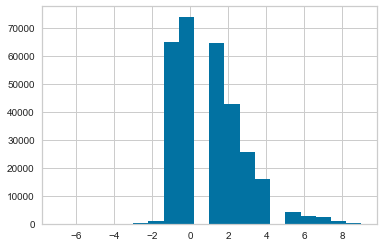

In [70]:
dfRandomN['income_diff'].hist(bins=20)

In [71]:
dfRandomN['pc_h_resident_property_val_perc_sqrt']=list(map(SqrtNormalise, 
                                                                   dfRandomN['pc_h_resident_property_val_perc_int']))

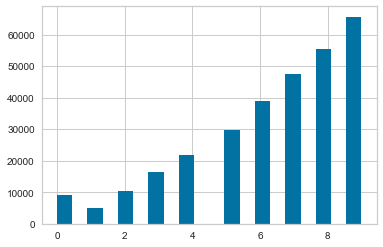

In [72]:
dfRandomN['pc_h_resident_property_val_perc_sqrt'].hist(bins=20)

# Derive the Target Class Using Experian and Indicia Current BARB

In [73]:
# dfRandomN['hc_target']=list(map(lambda x, y: 1 if x==1 and str(y).upper().find('HC') != -1 else 0,
#                                 dfRandomN['h_households_with_children_v3_int'],dfRandomN['barb']))

#dfRandomN['hc_target'] =  list(map(lambda x: 1 if x==1 else 0, dfRandomN['h_households_with_children_v3_int']))

# 'watch_ch_content', 'watch_parents_content', 'watch_diverse_ch_content', 'watch_repeat_ch_content', 'watch_ch_oi_content'
# in combination with pc_young_person_at_addr

# pc_h_lone_parent and income_diff_pc

def hc_target_comb (row):
   if row['h_households_with_children_v3_int'] == 1 :
      return 1
   elif row['watch_ch_content'] == 1 :
      return 1
   elif row['watch_diverse_ch_content'] == 1 :
      return 1
   elif row['watch_repeat_ch_content'] == 1:
      return 1
   elif row['watch_ch_oi_content']  == 1:
      return 1
   elif row['pc_young_person_at_addr'] == 1:
      return 1
   elif row['pc_h_lone_parent'] == 1:
      return 1 
   return 0

dfRandomN['hc_target_comb'] = dfRandomN.apply (lambda row: hc_target_comb (row),axis=1)

dfRandomN.head()

##take the extra fields added int the target class out of X_train and X_test

,viewer_id,gender,age,title,barb,lifestage,pc_h_resident_property_val_perc,pc_p_personal_income_band_v3,pc_h_household_comp,pc_h_income_band_v3,...,watch_parents_content,watch_diverse_ch_content,watch_repeat_ch_content,watch_ch_oi_content,income_diff,income_diff_pc,income_diff_pos,income_diff_pc_pos,pc_h_resident_property_val_perc_sqrt,hc_target_comb
0,00024436-1ae8-45a3-a12b-bb99b7b17d07,M,25.0,Mr,a2.a3.ad.axa.h5.hw.m3.me,Active,24,2,05,3,...,0,0,0,0,0,1,0,1,4,0
1,000410f9-441e-4f11-bddb-632c78dfed62,M,36.0,Mr,aa.ad.h5.ha.hc.hw.ma.me,Active,83,5,00,7,...,0,0,0,0,1,2,1,1,9,1
2,0011a226-afee-4570-9ca1-39d974b85eec,F,23.0,Miss,a2.a3.aa.ad.h5.ha.hw.w3.wa.wo,Inactive,58,3,03,4,...,0,0,0,0,1,1,1,1,7,0
3,0026c824-9f0c-4ed1-9032-5355d570eccb,F,68.0,Mrs,aa.ad.ha.hw.wa.wo,Inactive,96,6,01,7,...,0,0,0,0,-1,1,0,1,9,0
4,00333af0-8484-42a9-b82c-29e03f930aae,M,73.0,Mr,aa.ad.ha.hw.ma.me,Active,69,4,01,6,...,0,0,0,0,1,2,1,1,8,0


# Label Encode and One-Hot-Encode Fields for Training

In [74]:
idFeatures = ['viewer_id']
numericFeatures = ['age_sqrt', 'pc_h_resident_property_val_perc_sqrt', 'pc_h_affluent',  'income_diff_pc',
                   'percent_weekday_streaming_float_log', 'watch_parents_content', 'avg_sch_break_viewing', 
                   'avg_sch_break_choi_viewing']

categoricalFeatures=['gender', 'title', 'pc_h_household_comp', 'pc_h_family_lifestage_2011',
                     'pc_p_marital_status', 'top_subgenre', 'top_hour_of_day', 'top_hour_of_day_ch_content', 
                     'top_hour_of_day_choi_content', 'weekday_view_bucket', 'area_class1', 'area_class2',
                     'area_class3']

classFeatures = ['hc_target_comb', 'barb']

In [75]:
# Convert None into NONE values

dfRandomN['area_class1']=list(map(MakeNoneIntoValues, dfRandomN['area_class1']))
dfRandomN['area_class2']=list(map(MakeNoneIntoValues, dfRandomN['area_class2']))
dfRandomN['area_class3']=list(map(MakeNoneIntoValues, dfRandomN['area_class3']))
dfRandomN['gender']=list(map(MakeNoneIntoValues, dfRandomN['gender']))
dfRandomN['top_subgenre']=list(map(MakeNoneIntoValues, dfRandomN['top_subgenre']))
dfRandomN['title']=list(map(MakeNoneIntoValues, dfRandomN['title']))

In [76]:
# perform one-hot-encoding

gsCAT = Smarties()
dfRandomNcats = gsCAT.fit_transform(dfRandomN[categoricalFeatures])

In [77]:
# combine encoded and numerical features to create a final set
# combine encoded features into one data frame
dfRandomNEncoded=pd.concat([dfRandomNcats, dfRandomN[numericFeatures], dfRandomN['hc_target_comb'],
                            dfRandomN[idFeatures]], axis=1)

In [78]:
len(dfRandomNEncoded.columns)

263

# Split Data Into Train and Test

In [79]:
used_columns = list(dfRandomNcats.columns) + numericFeatures

X_train, X_test, y_train, y_test = train_test_split(dfRandomNEncoded[used_columns], 
                                                    dfRandomNEncoded['hc_target_comb'], 
                                                    test_size=0.35, random_state=11)

# Grid Search Cross-Validation for Max_Depth, Class_Weight and Min_Sample_Split

In [80]:
scoring_basic = {'Recall': make_scorer(recall_score, pos_label=1), 'Accuracy': make_scorer(accuracy_score, normalize=True)}
scoring_f1 = {'F1': make_scorer(f1_score, pos_label=1)}

In [34]:
gs_cv = GridSearchCV(RandomForestClassifier(n_estimators=500, criterion = 'entropy', random_state=11, oob_score=True),
                     param_grid = {'min_samples_split': range(5, 20, 5), 'max_depth': range(12, 28, 3),
                                   'class_weight': [{1:0.60, 0:0.40}, {1:50, 0:50}, {1:65, 0:35}]},
                    scoring=scoring_f1, refit = 'F1')

In [35]:
gs_cv.fit(X_train, y_train)

KeyboardInterrupt: 

In [61]:
gs_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={1: 65, 0: 35},
            criterion='entropy', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=11,
            verbose=0, warm_start=False)

In [62]:
gs_cv.best_score_

0.6134954111056071

# Fit and Predict Using RFC

In [81]:
clfRFC = RandomForestClassifier(n_estimators=600, max_depth = 21, criterion = 'entropy', random_state=11,
                                min_samples_split=15, oob_score=True, class_weight={1:0.65, 0:0.35})

In [82]:
clfRFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 0.65, 0: 0.35},
            criterion='entropy', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=True, random_state=11,
            verbose=0, warm_start=False)

In [83]:
predictionsclfRFC = clfRFC.predict(X_test)
print ("Accuracy score: ", accuracy_score(y_test, predictionsclfRFC))
print(classification_report(y_test, predictionsclfRFC))

Accuracy score:  0.7205333333333334
             precision    recall  f1-score   support

          0       0.87      0.51      0.64     51310
          1       0.66      0.92      0.77     53690

avg / total       0.76      0.72      0.71    105000



In [84]:
# check what happens on train test - is the difference in accuracy large?
predictionsclfRFC_train = clfRFC.predict(X_train)
print ("Accuracy score: ", accuracy_score(y_train, predictionsclfRFC_train))
print(classification_report(y_train, predictionsclfRFC_train))

Accuracy score:  0.7300102564102564
             precision    recall  f1-score   support

          0       0.88      0.52      0.65     94890
          1       0.67      0.93      0.78    100110

avg / total       0.77      0.73      0.72    195000



In [85]:
feature_importance = sorted(tuple(zip(dfRandomNEncoded[used_columns].columns,clfRFC.feature_importances_)),
                            key=operator.itemgetter(1))

In [86]:
feature_importance[:10:-1]

[('top_hour_of_day_choi_content_evening', 0.1983403906216407),
 ('age_sqrt', 0.12930631625495775),
 ('top_hour_of_day_choi_content_day', 0.11690973418374147),
 ('top_hour_of_day_choi_content_evening commute', 0.08007935884868772),
 ('avg_sch_break_choi_viewing', 0.06409315980265852),
 ('top_hour_of_day_choi_content_night', 0.04989591322849939),
 ('top_subgenre_{"id":"US COMEDY","ranking":"1"}', 0.03892331225061573),
 ('top_hour_of_day_ch_content_day', 0.027833328055473068),
 ('top_hour_of_day_choi_content_morning commute', 0.027470289515127148),
 ('top_subgenre_{"id":"TALENT SHOWS","ranking":"1"}', 0.025565280085690718),
 ('top_hour_of_day_ch_content_evening', 0.021598523306755865),
 ('top_hour_of_day_ch_content_evening commute', 0.016978968197741005),
 ('top_subgenre_{"id":"CRIME AND THRILLERS","ranking":"1"}',
  0.01187375888740356),
 ('top_hour_of_day_ch_content_morning commute', 0.008980633185847513),
 ('watch_parents_content', 0.007723720397370085),
 ('pc_h_resident_property_val_p

# Read In the PWC dataset

In [88]:
# Read in the PWC dataset

dfPWC = pd.DataFrame()
used_columns =  " viewer_id, gender, age, title, barb, lifestage, " + \
                " pc_h_resident_property_val_perc, pc_p_personal_income_band_v3, " + \
                " pc_h_household_comp, pc_h_income_band_v3, " + \
                " pc_length_of_residence, pc_h_lifestage, pc_h_number_of_bedrooms, pc_p_marital_status, " + \
                " pc_h_prperty_type_v2, pc_h_family_lifestage_2011, pc_h_lone_parent, pc_young_person_at_addr, " + \
                " pc_p_affluence_v2, pc_h_affluence_v2, h_households_with_children_v3, " + \
                " p_personal_income_band_v3, h_income_band_v3, " + \
                " weekday_streaming, nonweekday_streaming, " + \
                " top_genre_id, top_subgenre, watch_ch_content_sum, watch_diverse_ch_content_sum, " + \
                " watch_parents_content_sum, watch_repeat_ch_content_sum, watch_ch_oi_content_sum, top_hour_of_day, " + \
                " top_hour_of_day_ch_content, top_hour_of_day_choi_content, percent_weekday_streaming, weekday_view_bucket, " + \
                " area_class1, area_class2, area_class3, " + \
                " avg_sprbrk_viewing, avg_sumbrk_viewing, avg_nonsch_hol_viewing, avg_sprbrk_ch_viewing, " + \
                " avg_sumbrk_ch_viewing, avg_nonsch_hol_ch_viewing "

query_data = "Select " + used_columns + \
              " from sandbox.pwc_summary_hc_2018_es;"

try: 
    con = get_svv_connection()

    cur = con.cursor()

    cur.execute(query_data)

    cols = [item.lstrip().rstrip() for item in used_columns.split(',')]
    dfPWC = pd.DataFrame(cur.fetchall(), columns = cols)
    
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

# Process The PWC Dataset

In [89]:
dfPWC['h_households_with_children_v3_int']=list(map(int, dfPWC['h_households_with_children_v3']))
dfPWC['pc_h_resident_property_val_perc_int'] = list(map(int, dfPWC['pc_h_resident_property_val_perc']))

dfPWC['pc_p_personal_income_band_v3_int'] = list(map(int, dfPWC['pc_p_personal_income_band_v3']))

dfPWC['pc_h_income_band_v3_int'] = list(map(int, dfPWC['pc_h_income_band_v3']))

In [90]:
dfPWC['pc_length_of_residence_int'] = list(map(int, dfPWC['pc_length_of_residence']))
dfPWC['pc_h_number_of_bedrooms_int'] = list(map(int, dfPWC['pc_h_number_of_bedrooms']))

dfPWC['pc_p_affluence_v2_int']=list(map(int, dfPWC['pc_p_affluence_v2']))
dfPWC['pc_h_affluence_v2_int']=list(map(int,dfPWC['pc_h_affluence_v2']))

In [91]:
dfPWC['p_personal_income_band_v3_int'] = list(map(int, dfPWC['p_personal_income_band_v3']))
dfPWC['h_income_band_v3_int'] = list(map(int, dfPWC['h_income_band_v3']))

dfPWC['weekday_streaming_float'] = list(map(lambda x: float(x) if str(x)!='None' else 0,
                                                dfPWC['weekday_streaming']))

dfPWC['nonweekday_streaming_float'] = list(map(lambda x: float(x) if str(x)!='None' else 0,
                                                dfPWC['nonweekday_streaming']))
dfPWC['percent_weekday_streaming_float'] = list(map(lambda x: float(x) if str(x)!='None' else 0,
                                                dfPWC['percent_weekday_streaming']))

In [92]:
len(dfPWC.loc[dfPWC['h_households_with_children_v3_int']==1])/len(dfPWC.loc[(dfPWC['h_households_with_children_v3_int']==1) | (dfPWC['h_households_with_children_v3_int']==0)])

0.1774193548387097

In [93]:
dfPWC['age_sqrt'] = list(map(FixAge, dfPWC['age']))

dfPWC['weekday_streaming_float'] = list(map(TransformNones,dfPWC['weekday_streaming_float'] ))

dfPWC['nonweekday_streaming_float'] = list(map(TransformNones,dfPWC['nonweekday_streaming_float'] ))

dfPWC['percent_weekday_streaming_float'] = list(map(TransformNones,dfPWC['percent_weekday_streaming_float'] ))

dfPWC['percent_weekday_streaming_float_log'] = list(map(Log10Normalise,dfPWC['percent_weekday_streaming_float'] ))

dfPWC['p_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfPWC['p_personal_income_band_v3_int']))
dfPWC['h_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfPWC['h_income_band_v3_int']))

# Do the same for the Postcode Ones
dfPWC['pc_p_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfPWC['pc_p_personal_income_band_v3_int']))
dfPWC['pc_h_affluent'] = list(map(lambda x: 1 if x>=4 else 0, dfPWC['pc_h_income_band_v3_int']))

In [94]:
dfPWC['watch_ch_content']=list(map(lambda x: 1 if x>=1 else 0, dfPWC['watch_ch_content_sum']))
dfPWC['watch_parents_content']=list(map(lambda x: 1 if x>=1 else 0, dfPWC['watch_parents_content_sum']))
dfPWC['watch_diverse_ch_content']=list(map(lambda x: 1 if x>=1 else 0, dfPWC['watch_diverse_ch_content_sum']))
dfPWC['watch_repeat_ch_content'] = list(map(lambda x: 1 if x>=1 else 0, dfPWC['watch_repeat_ch_content_sum']))
dfPWC['watch_ch_oi_content'] = list(map(lambda x: 1 if x>=1 else 0, dfPWC['watch_ch_oi_content_sum']))

In [95]:
dfPWC['income_diff'] = dfPWC['h_income_band_v3_int'] - dfPWC['p_personal_income_band_v3_int']
dfPWC['income_diff_pc'] = dfPWC['pc_h_income_band_v3_int'] - dfPWC['pc_p_personal_income_band_v3_int']

In [96]:
dfPWC['income_diff_pos'] = list(map(lambda x: 1 if x>0 else 0, dfPWC['income_diff']))
dfPWC['income_diff_pc_pos'] = list(map(lambda x: 1 if x>0 else 0, dfPWC['income_diff_pc']))

In [97]:
dfPWC['pc_h_resident_property_val_perc_sqrt']=list(map(SqrtNormalise, 
                                                                   dfPWC['pc_h_resident_property_val_perc_int']))

In [98]:
# dfPWC['hc_target']=list(map(lambda x, y: 1 if x==1 and str(y).upper().find('HC') != -1 else 0,
#                                 dfPWC['h_households_with_children_v3_int'],dfPWC['barb']))

#dfPWC['hc_target'] = list(map(lambda x: 1 if x==1 else 0, dfPWC['h_households_with_children_v3_int']))

def pwc_target_comb (row):
   if row['h_households_with_children_v3_int'] == 1 :
      return 1
   elif row['watch_ch_content'] == 1 :
      return 1
   elif row['watch_diverse_ch_content'] == 1 :
      return 1
   elif row['watch_repeat_ch_content'] == 1:
      return 1
   elif row['watch_ch_oi_content']  == 1:
      return 1
   elif row['pc_young_person_at_addr'] == 1:
      return 1
   elif row['pc_h_lone_parent'] == 1:
      return 1 
   return 0

dfPWC['pwc_target_comb'] = dfPWC.apply (lambda row: pwc_target_comb (row),axis=1)

In [99]:
dfPWC['area_class1']=list(map(MakeNoneIntoValues, dfPWC['area_class1']))
dfPWC['area_class2']=list(map(MakeNoneIntoValues, dfPWC['area_class2']))
dfPWC['area_class3']=list(map(MakeNoneIntoValues, dfPWC['area_class3']))
dfPWC['gender']=list(map(MakeNoneIntoValues, dfPWC['gender']))
dfPWC['top_subgenre']=list(map(MakeNoneIntoValues, dfPWC['top_subgenre']))
dfPWC['title']=list(map(MakeNoneIntoValues, dfPWC['title']))

In [100]:
dfPWC['avg_sprbrk_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfPWC['avg_sprbrk_viewing']))

dfPWC['avg_sumbrk_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfPWC['avg_sumbrk_viewing']))

dfPWC['avg_nonsch_hol_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfPWC['avg_nonsch_hol_viewing']))

dfPWC['avg_sprbrk_ch_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfPWC['avg_sprbrk_ch_viewing']))

dfPWC['avg_sumbrk_ch_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfPWC['avg_sumbrk_ch_viewing']))

dfPWC['avg_nonsch_hol_ch_viewing_float'] = list(map(lambda x: 0 if x is None else float(x),
                                                     dfPWC['avg_nonsch_hol_ch_viewing']))

In [101]:
dfPWC['avg_sch_break_viewing'] =  list(map(lambda x,y,z: 1 if x>z or y>z else 0, 
                                               dfPWC['avg_sprbrk_viewing_float'],
                                               dfPWC['avg_sumbrk_viewing_float'],
                                               dfPWC['avg_nonsch_hol_viewing_float']))

In [102]:
dfPWC['avg_sch_break_choi_viewing'] =  list(map(lambda x,y,z: 1 if x>z or y>z else 0, 
                                               dfPWC['avg_sprbrk_ch_viewing_float'],
                                               dfPWC['avg_sumbrk_ch_viewing_float'],
                                               dfPWC['avg_nonsch_hol_ch_viewing_float']))

In [103]:
dfPWCcats = gsCAT.transform(dfPWC[categoricalFeatures])

In [104]:
numericFeaturesPWC = numericFeatures

In [106]:
dfPWCEncoded=pd.concat([dfPWCcats, dfPWC[numericFeaturesPWC], dfPWC['pwc_target_comb'],
                            dfPWC[idFeatures]], axis=1)

In [107]:
len(dfPWCEncoded.columns)

263

In [108]:
used_columnsPWC = list(dfPWCcats.columns) + numericFeaturesPWC

In [110]:
predictionsclfRFC = clfRFC.predict(dfPWCEncoded[used_columnsPWC])
print ("Accuracy score: ", accuracy_score(dfPWC['pwc_target_comb'], predictionsclfRFC))
print(classification_report(dfPWC['pwc_target_comb'], predictionsclfRFC))

Accuracy score:  0.8729838709677419
             precision    recall  f1-score   support

          0       0.93      0.86      0.89       307
          1       0.80      0.89      0.84       189

avg / total       0.88      0.87      0.87       496



In [111]:
dfPWC['hc_predicted'] = predictionsclfRFC
dfPWC['hc_prob_1']=[x[:][1] for x in clfRFC.predict_proba(dfPWCEncoded[used_columnsPWC])]

In [112]:
dfPWC.to_csv("HC_FullPostcode.csv")